In [2]:
%matplotlib inline 

from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import h5py


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Format plots 
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)

In [3]:
from scipy.sparse import csr_matrix
def nufd(x):
    n = len(x)
    h = x[1:]-x[:n-1]
    a0 = -(2*h[0]+h[1])/(h[0]*(h[0]+h[1]))
    ak = -h[1:]/(h[:n-2]*(h[:n-2]+h[1:]))
    an = h[-1]/(h[-2]*(h[-1]+h[-2]))
    b0 = (h[0]+h[1])/(h[0]*h[1]) 
    bk = (h[1:] - h[:n-2])/(h[:n-2]*h[1:])
    bn = -(h[-1]+h[-2])/(h[-1]*h[-2])
    c0 = -h[0]/(h[1]*(h[0]+h[1]))
    ck = h[:n-2]/(h[1:]*(h[:n-2]+h[1:]))
    cn = (2*h[-1]+h[-2])/(h[-1]*(h[-2]+h[-1]))
    val  = np.hstack((a0,ak,an,b0,bk,bn,c0,ck,cn))
    row = np.tile(np.arange(n),3)
    dex = np.hstack((0,np.arange(n-2),n-3))
    col = np.hstack((dex,dex+1,dex+2))
    D = csr_matrix((val,(row,col)),shape=(n,n))
    return D

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [5]:
folder = "Pulsatile/T30/"
filenameh5 = "Stats-T30-128.03.h5"

with h5py.File(folder+filenameh5, 'r') as hf:
    stats = hf['stats'][:]
    z = hf['z'][:]

nz = 129

nx = 128
ny = 128
nz = 129
run = "03"
number_of_phases = 32 # over half a period
number_of_periods = 1


z_all = np.zeros(nz+2)
z_all[0] = -1.
z_all[-1] = 1.
z_all[1:-1] = np.copy(z)
a_metrics = np.zeros(nz)
c_metrics = np.zeros(nz)
a_metrics[:] = 1. / ((z_all[1:-1] - z_all[0:-2])*(z_all[2:]-z_all[0:-2]))
c_metrics[:] = 1. / ((z_all[2:] - z_all[1:-1])*(z_all[2:]-z_all[0:-2]))
dz = nufd(z_all)


nu = 1./2000
i_mean = 0
i_ms = 1
i_skew = 2
i_flat = 3
nstats = 4
i_u = 0
i_uu = 1
i_vv = 2
i_ww = 3
i_T = 4
i_uw = 5
i_wT = 6
i_dudy = 7
i_eps = 8
i_dTdy = 9
nscalars = 10

In [6]:
k = np.zeros((32,nz))
for i in [i_uu,i_vv,i_ww]:
    k += stats[:,i,:]
k /= 2.
nu_t = 0.09*k**2/stats[:,i_eps,:]
alpha_t = -stats[:,i_wT,:]/stats[:,i_dTdy,:]
Prt = nu_t/alpha_t
print(Prt.shape, z.shape)

(32, 129) (129,)


In [6]:
# k = np.sum(stat[iphase,:,:],axis = 0)/2
# k = np.sum(stats[iphase,i_uu:i_ww+1,:],axis = 0)/2


In [7]:
# phase = 10
# plt.scatter(z, Prt[phase,:])

$$
\nu_t = C_\nu \frac{k^2}{\epsilon}
$$
$$
\frac{\partial \bar{T}}{\partial t} = \frac{\partial}{\partial z} \Big( \alpha + \frac{\nu_t}{Pr_t} \Big) \frac{\partial \bar{T}}{\partial }
$$

In [8]:
# nu_t = -stats[:,i_uw,:]/stats[:,i_dudy]
# alpha_t = -stats[:,i_wT,:]/stats[:,i_dTdy]
# Prt = nu_t/alpha_t
# print(Prt.shape, z.shape)

In [9]:
Prt_disp = pd.DataFrame(Prt.transpose(), index=['z=%.3f' % z[i] for i in range(len(z))], columns = [f'Phase {n}' for n in range(1, 33)])
print(type(z))
Prt_disp.tail()

<class 'numpy.ndarray'>


,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6,Phase 7,Phase 8,Phase 9,Phase 10,...,Phase 23,Phase 24,Phase 25,Phase 26,Phase 27,Phase 28,Phase 29,Phase 30,Phase 31,Phase 32
z=0.996,0.486463,0.949736,2.687892,6.020536,10.092255,14.413536,17.054001,15.249281,10.100369,6.730057,...,17.257095,15.152474,9.264485,5.946616,5.207336,4.532282,3.642784,2.412239,1.368238,0.659191
z=0.997,0.357367,0.702441,2.007514,4.524044,7.585789,10.797726,12.736396,11.261929,7.266623,4.821013,...,12.855702,11.220941,6.699476,4.227702,3.678934,3.226690,2.589448,1.732022,0.994400,0.484444
z=0.998,0.238091,0.471225,1.356410,3.071756,5.158615,7.325972,8.618050,7.548954,4.781400,3.163999,...,8.684465,7.543947,4.418102,2.757711,2.391061,2.108658,1.690547,1.138883,0.659083,0.323024
z=0.999,0.127051,0.253034,0.731090,1.662434,2.802018,3.974686,4.664275,4.053804,2.535694,1.674870,...,4.697042,4.063318,2.343841,1.453468,1.258124,1.113437,0.892396,0.603692,0.350946,0.172460
z=1.000,0.022993,0.046398,0.134676,0.307554,0.517405,0.731237,0.854482,0.737346,0.456814,0.301019,...,0.860985,0.741091,0.421862,0.260335,0.225159,0.199660,0.159993,0.108494,0.063261,0.031140


In [10]:
prt_vect = [Prt[i,:] for i in range(len(Prt))]
prt_vect = np.concatenate(prt_vect)
print(prt_vect)
print(prt_vect.shape)

[0.025 0.138 0.258 ... 0.323 0.172 0.031]
(4128,)


In [11]:
z_vect = [z for _ in range(32)]
z_vect = np.concatenate(z_vect)
print(z_vect)
print(z_vect.shape)

[-1.    -0.999 -0.998 ...  0.998  0.999  1.   ]
(4128,)


In [12]:
phase_vect = [np.full(shape=129, fill_value=i, dtype=np.int) for i in range(1, 33)]
phase_vect = np.concatenate(phase_vect)
print(phase_vect)
print(phase_vect.shape)

[ 1  1  1 ... 32 32 32]
(4128,)


### Create Panda DataFrame with vector form of input matrices

In [13]:
prt_pd = pd.DataFrame({'phase':phase_vect, 'z': z_vect, 'Pr': prt_vect})
dataset = prt_pd
prt_pd.tail()

,phase,z,Pr
4123,32,0.996461,0.659191
4124,32,0.997368,0.484444
4125,32,0.998200,0.323024
4126,32,0.998964,0.172460
4127,32,0.999665,0.031140


# DNN: Predict Prandtl Number 
... as a function of channel height and phase number 

In [14]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(129, activation='relu'),
        layers.Dense(129, activation='relu'),
        layers.Dense(129, activation='relu'),
        
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [15]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [16]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset)

      phase         z         Pr
1065      9 -0.879425   4.487105
45        1 -0.682534   0.376864
1569     13 -0.960326  10.749572
1280     10  0.990552  22.232031
3249     26 -0.946736  25.731303
...     ...       ...        ...
1911     15  0.951643   3.030469
2538     20  0.766439   0.370121
74        1  0.411622   0.234787
515       4  0.999665   0.307554
1309     11 -0.967685  27.233634

[3302 rows x 3 columns]


In [17]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
print(train_features)

train_labels = train_features.pop('Pr')
test_labels = test_features.pop('Pr')

      phase         z         Pr
1065      9 -0.879425   4.487105
45        1 -0.682534   0.376864
1569     13 -0.960326  10.749572
1280     10  0.990552  22.232031
3249     26 -0.946736  25.731303
...     ...       ...        ...
1911     15  0.951643   3.030469
2538     20  0.766439   0.370121
74        1  0.411622   0.234787
515       4  0.999665   0.307554
1309     11 -0.967685  27.233634

[3302 rows x 3 columns]


#### Normalize Input Layer

In [18]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [19]:
dnn_model = build_and_compile_model(normalizer)

In [20]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 129)               387       
_________________________________________________________________
dense_1 (Dense)              (None, 129)               16770     
_________________________________________________________________
dense_2 (Dense)              (None, 129)               16770     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 130       
Total params: 34,062
Trainable params: 34,057
Non-trainable params: 5
_________________________________________________________________


In [21]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=500)

CPU times: user 13min 4s, sys: 11min 55s, total: 25min
Wall time: 3min 37s


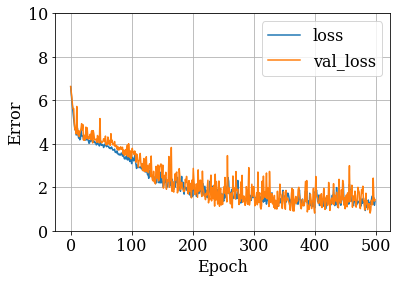

In [22]:
plot_loss(history)

In [23]:
def plot_z(x, y):
    plt.scatter(train_features['z'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('z')
    plt.ylabel('Pr')
    plt.legend()
    plt.ylim([-10, 10])

In [24]:
# print(z[10])
# print(phase_vect[:129])
# print(np.full(shape=129, fill_value=phase, dtype=np.int))

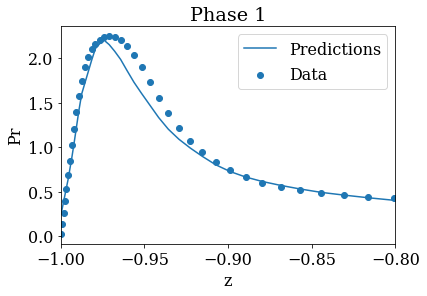

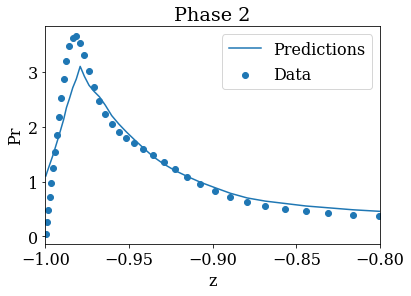

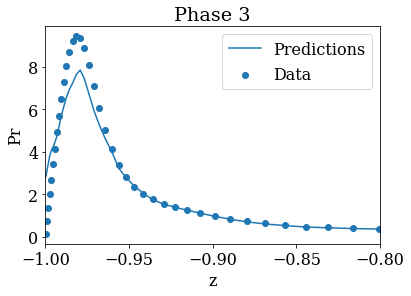

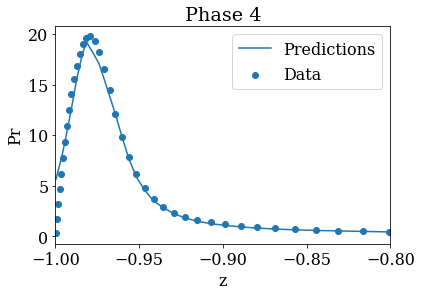

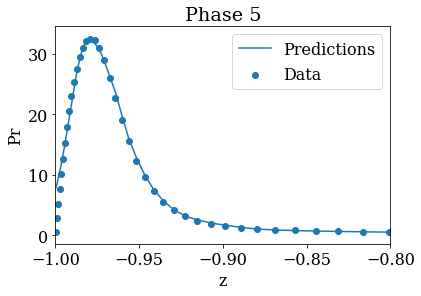

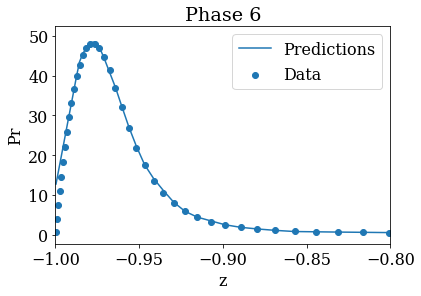

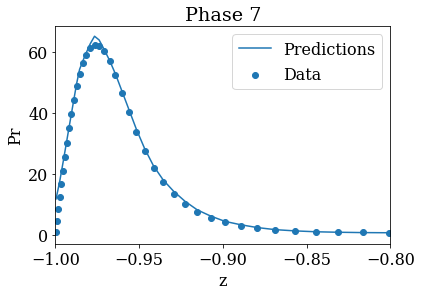

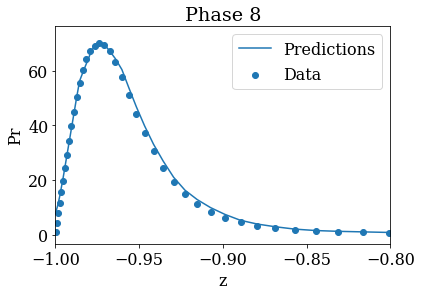

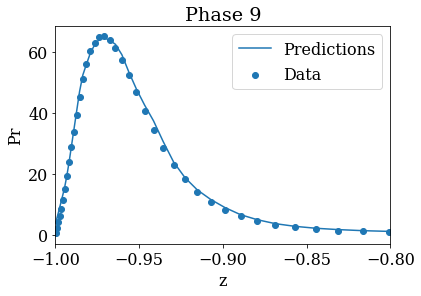

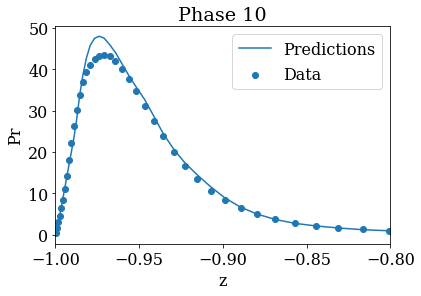

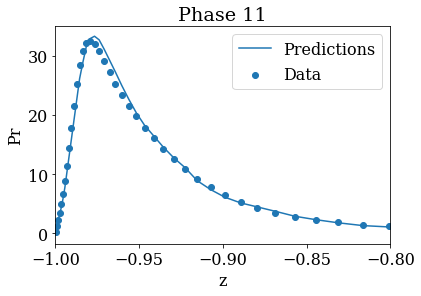

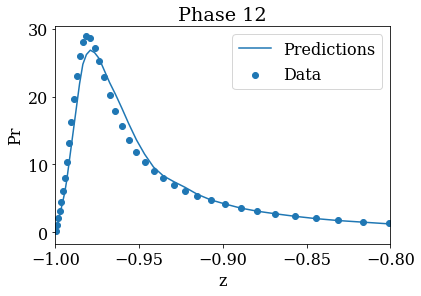

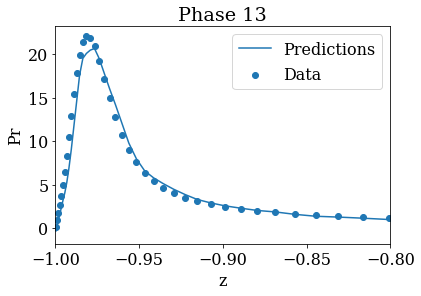

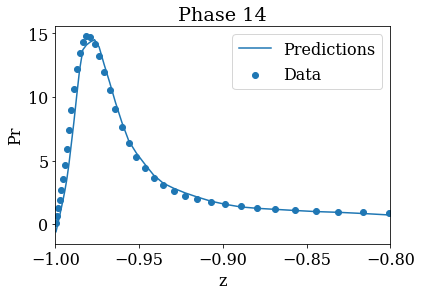

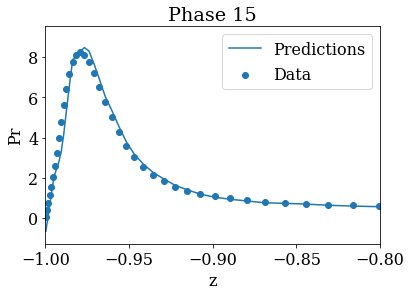

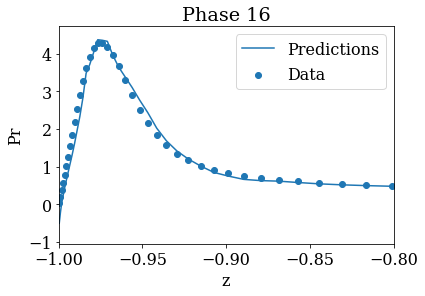

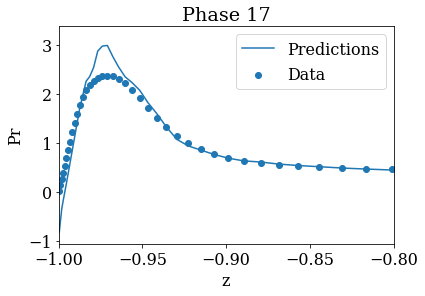

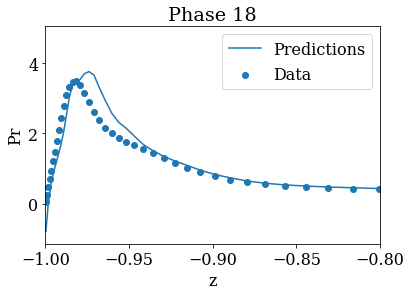

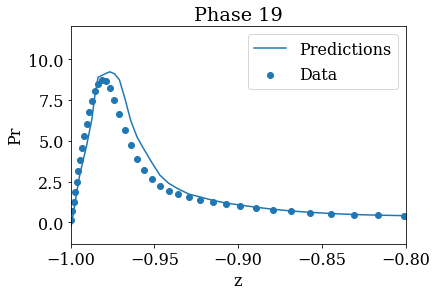

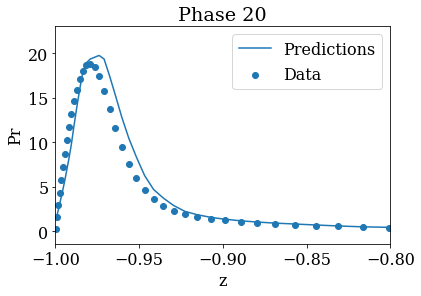

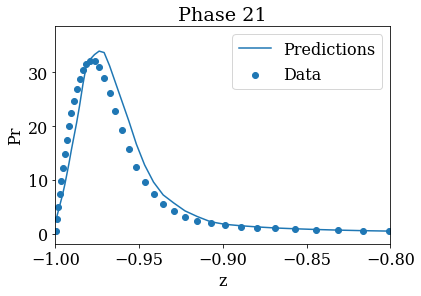

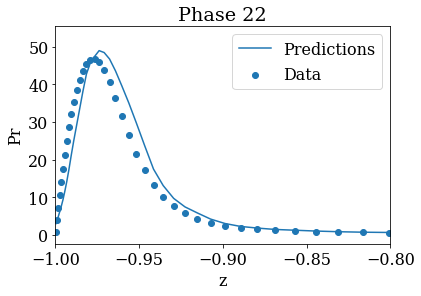

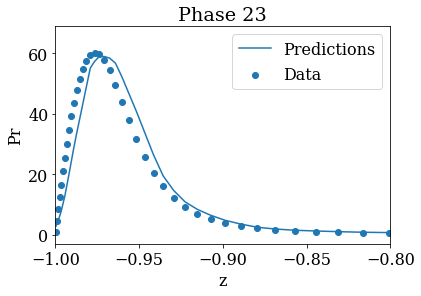

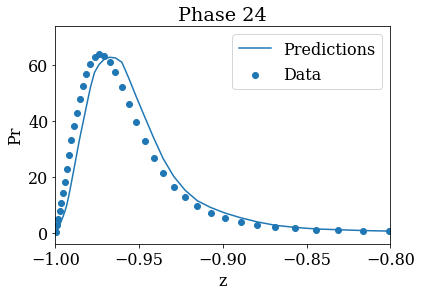

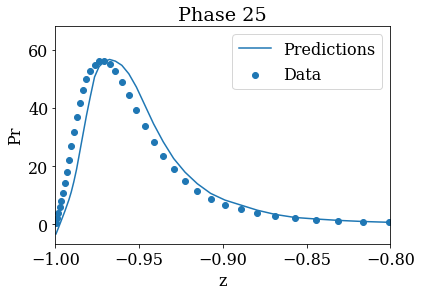

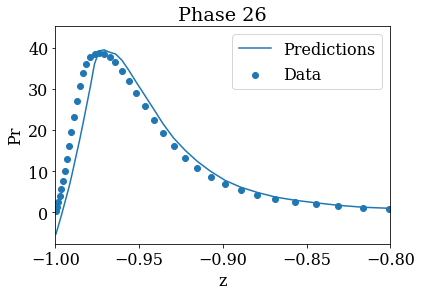

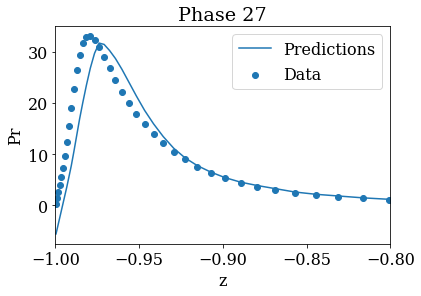

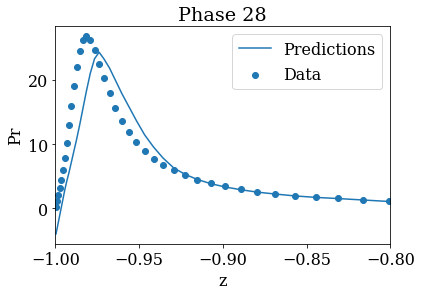

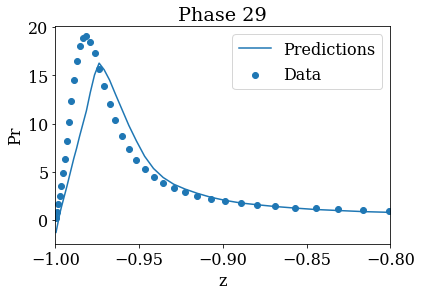

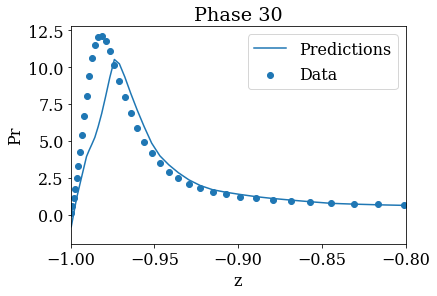

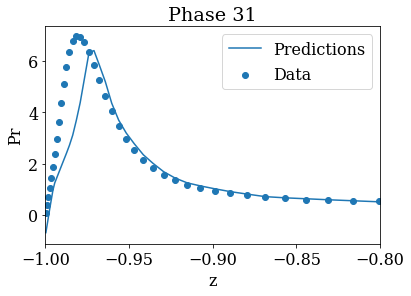

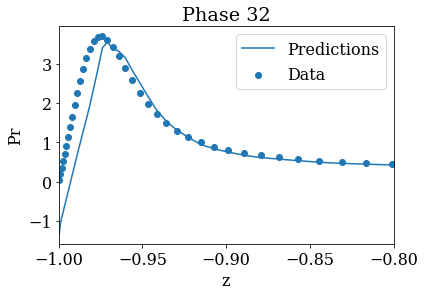

In [25]:
for phase in range(1,33):
    z = z
    ph = np.full(shape=129, fill_value=phase, dtype=np.int)
    predition_input = pd.DataFrame({'phase': ph, 'z': z})

    prediction_output = dnn_model.predict(predition_input)  # input

    plt.plot(z,prediction_output, label='Predictions')
    plt.scatter(z,Prt[phase-1,:], label='Data')
    plt.ylabel('Pr')
    plt.xlabel('z')
    plt.xlim([-1,-0.8])
    plt.legend()
    plt.title(f'Phase {phase}')
    plt.show()

In [7]:
for phase in range(1,33):
    z = z
    ph = np.full(shape=129, fill_value=phase, dtype=np.int)
    predition_input = pd.DataFrame({'phase': ph, 'z': z})

    prediction_output = dnn_model.predict(predition_input)  # input

    plt.plot(z,prediction_output, label='Predictions')
    plt.scatter(z,Prt[phase-1,:], label='Data')
    plt.ylabel('Pr')
    plt.xlabel('z')
#     plt.xlim([-1,-0.8])
    plt.legend()
    plt.title(f'Phase {phase}')
    plt.show()

NameError: name 'dnn_model' is not defined

In [26]:
%%time
prediction_output = dnn_model.predict(predition_input)

CPU times: user 202 ms, sys: 138 ms, total: 340 ms
Wall time: 90 ms


$$
Pr_t = C k^\alpha \bigg\lvert\frac{\partial \bar{T}}{\partial z}\bigg\rvert^\beta \varepsilon^\gamma
$$

$$
Pr_t = f(k,\bigg\lvert\frac{\partial \bar{T}}{\partial z}\bigg\rvert)
$$